In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def calibrate():
    print("calibrating...")
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    print("done")        
    return objpoints, imgpoints

calibrating...
done


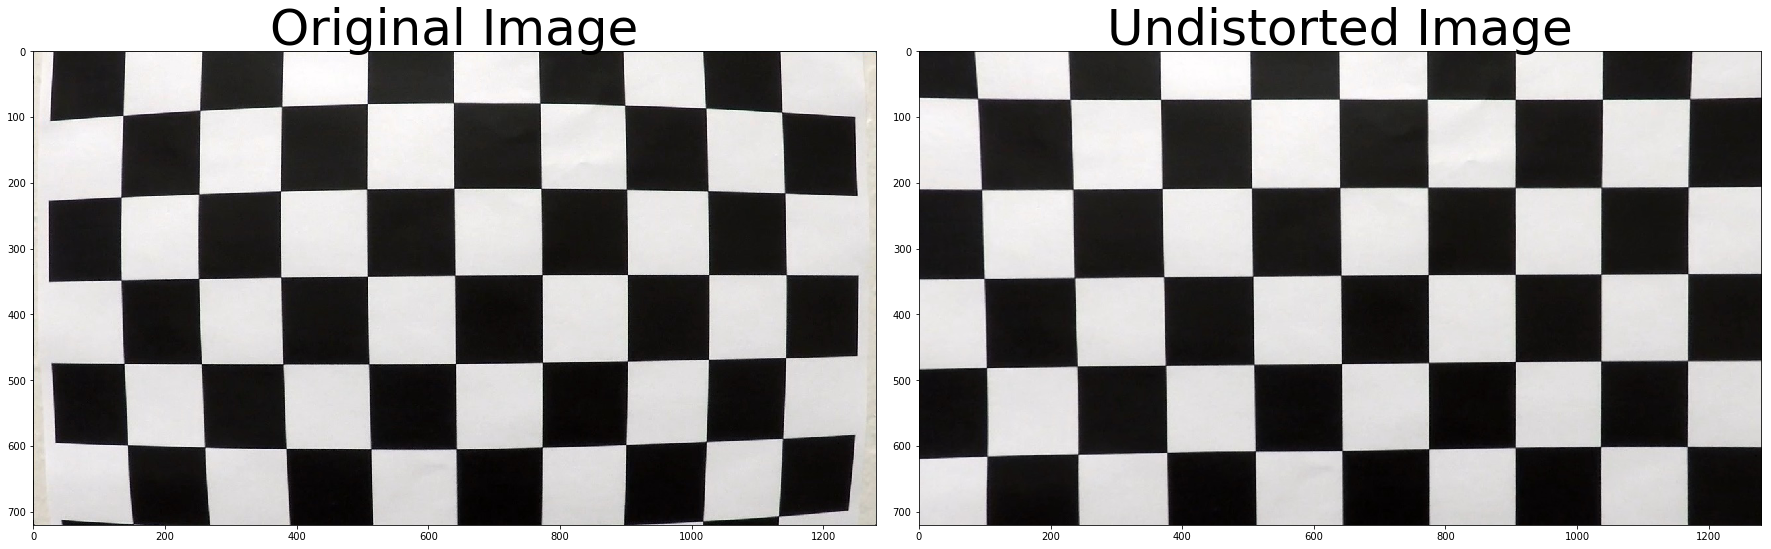

In [2]:
import matplotlib.image as mpimg

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

image = mpimg.imread('camera_cal/calibration1.jpg')

obj, impoints= calibrate()
undst = cal_undistort(image, obj, impoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [3]:
#color space transform and application of sobel operator
def hls_binary(img, s_thresh=(90, 255), sx_thresh=(20, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

#transformation of perspective
def perspectiveTransform(image):
    img_size = (image.shape[1], image.shape[0])
    src=np.float32([[750, 470], 
                   [1200, 720], 
                   [230, 720],
                   [550, 470],])

    dst=np.float32([[1000, 0], 
                    [1000, 720], 
                    [200, 720],
                    [200, 0],])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warpedImage = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warpedImage

In [4]:
#used for storage and evaluation of previous detections
class Line():
    def __init__(self):
        #iterate throug found lines
        self.iterate = 0
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #x values for detected line pixels
        self.allx = None  
        #slope of last point in polynomial fit 
        self.derivative = None


# Sanity checker 1: check difference in x values
def sanityXValues(lastLine, currentLine):
    if((lastLine.iterate > 0) and (abs(lastLine.bestx - np.mean(currentLine)) > 50 )):
        return False
    else:
        return True
    
# Sanity checker 2: check if difference in curvature 
def sanityCurvature(lastLine, curvature):
    myReturn = True
    if(lastLine.iterate > 0):
        myDelta = abs(lastLine.radius_of_curvature - curvature)
        if((myDelta) > 1000 ):
            myReturn = False
        else:
            myReturn = True
            
    return myReturn

# Sanity checker 2: check difference in slope of polynomial at position y=0
def sanitySlope(lastLine, derivativeCurrent):
    myReturn = True
    if((lastLine.iterate > 0)):
        mydiff = abs(derivativeCurrent - lastLine.derivative)
        if(mydiff > 0.05):
            myReturn = False
        else:
            myReturn = True
            
    return myReturn 

def findLines(image, M, Minv, binary_warped):

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    

    
############# My Code #############

    #get current defivative at position y=0
    leftDerivative_current =2*left_fit[0]*y_eval + left_fit[1]
    rightDerivative_current =2*right_fit[0]*y_eval + right_fit[1]
    
    #perform sanity checks
    if((sanityXValues(leftLine, left_fitx) == False) 
       or (sanityCurvature(leftLine, left_curverad) == False)
          or (sanitySlope(leftLine, leftDerivative_current) == False)):
        #sanity check failed. Use previous x values
        left_fitx = leftLine.allx
        
    if((sanityXValues(rightLine, right_fitx) == False) 
       or (sanityCurvature(rightLine, right_curverad) == False)
            or (sanitySlope(rightLine, rightDerivative_current) == False)):
        right_fitx = rightLine.allx
       
    #iteration  
    leftLine.iterate = (leftLine.iterate + 1)
    rightLine.iterate = (rightLine.iterate + 1)

    if(leftLine.iterate > 100):
        #remove oldest values
        leftLine.recent_xfitted.pop(0)
    #store last 100 left line x values 
    leftLine.recent_xfitted.append(left_fitx)
    #mean last 100 left line x values 
    leftLine.bestx = np.mean(leftLine.recent_xfitted)
    
    #same for right line
    if(rightLine.iterate > 100):
        rightLine.recent_xfitted.pop(0)
    rightLine.recent_xfitted.append(right_fitx)
    rightLine.bestx = np.mean(rightLine.recent_xfitted)

    #store last x values 
    leftLine.allx = left_fitx
    rightLine.allx = right_fitx
    
    #store curvature 
    leftLine.radius_of_curvature = left_curverad
    rightLine.radius_of_curvature = right_curverad
    
    #store derivative
    leftLine.derivative = leftDerivative_current
    rightLine.derivative = rightDerivative_current
    
    #camera is mounted at the center of vehicle.
    camera_position = image.shape[1]/2
    #get x points close to vehicle
    lane_center = (left_fitx[719] + right_fitx[719])
    #get vehicle position relative to lines
    vehicle_position = (camera_position - lane_center) * xm_per_pix
############# ############# #############


    # Create an image to draw the lines on
    warped_binary = binary_warped
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    img_size = (image.shape[1], image.shape[0])
    warped2 = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    #create thumbnail of warped image
    thumbnail = cv2.resize(warped2, (int(image.shape[1]/4), int(image.shape[0]/4)),  cv2.INTER_LANCZOS4) 

    #project thumbnail of warped image into original image
    result2=result
    result2[0:thumbnail.shape[0], 0:thumbnail.shape[1], :]=thumbnail#cv2.cvtColor(thumbnail, cv2.COLOR_HLS2RGB)
    
    #write current curvature and vehicle position
    cv2.putText(result2, str(left_curverad) , (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(result2, str(right_curverad) , (800, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.putText(result2, str(vehicle_position) , (600, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    
    return result2, left_fitx, right_fitx, ploty 

In [5]:
def processImage(image_raw):
    #undistort image
    image = cal_undistort(image_raw, obj, impoints)
    #perspective transform
    M, Minv, warpedImage = perspectiveTransform(image);
    #get a binary image version
    warped_binary = hls_binary(warpedImage)
    #find lines and project lines into image
    res, left_fitx, right_fitx, ploty = findLines(image, M, Minv, warped_binary)
    return res

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
if __name__ == '__main__':
    
    #create new Lines
    leftLine = Line();
    rightLine = Line();
    
    outputFile = 'project_video_rob.mp4'    
    originalClip = VideoFileClip('project_video.mp4')#.subclip(38,43)
    myClip = originalClip.fl_image(processImage)
    myClip.write_videofile(outputFile, audio=False)

[MoviePy] >>>> Building video project_video_rob.mp4
[MoviePy] Writing video project_video_rob.mp4


100%|█████████▉| 1260/1261 [05:47<00:00,  3.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_rob.mp4 



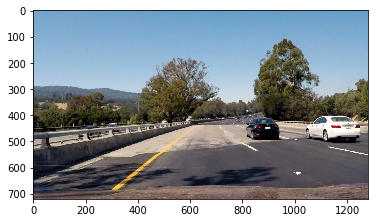

original image + roi


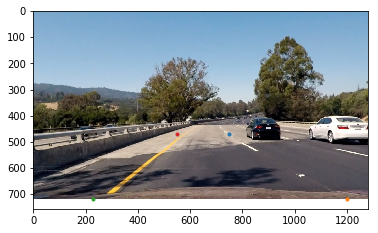

Preprocessed image 


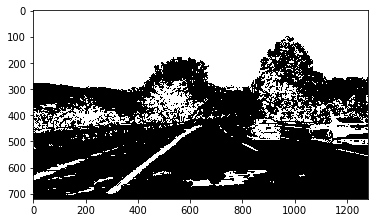

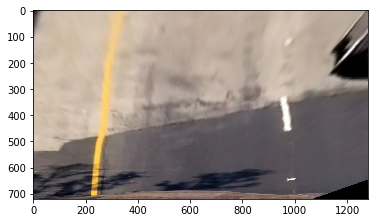

Warped and preprocessed 


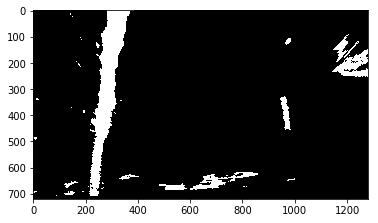

Lines identified 


NameError: name 'left_fitx' is not defined

In [7]:
### THIS PART IS ONLY FOR ILLUSTRATION ###

leftLine = Line();
rightLine = Line();

#read in image
image_raw = mpimg.imread('test4.jpg')
plt.imshow(image_raw)
plt.show()

image = cal_undistort(image_raw, obj, impoints)
print("original image + roi")
plt.imshow(image)
plt.plot(750, 470, '.')
plt.plot(1200, 720, '.')
plt.plot(230, 720, '.')
plt.plot(550, 470, '.')
plt.show()
plt.show()

print("Preprocessed image ")
preprocIllustration = hls_binary(image)
plt.imshow(preprocIllustration, cmap='gray')
plt.show()

M, Minv, warpedImage = perspectiveTransform(image);
plt.imshow(warpedImage)
plt.show()

print("Warped and preprocessed ")
warped_binary = hls_binary(warpedImage)
plt.imshow(warped_binary, cmap="gray")
plt.show()

print("Lines identified ")
plt.imshow(warped_binary, cmap="gray")
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)
x=plt.show()

print("Lines projected onto original image")
result, left_fitx, right_fitx, ploty = findLines(image, M, Minv, warped_binary)
plt.imshow(result)
plt.show()

